# [ LSTM - 잡코리아 기업평 긍정/부정 분류 ]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import re
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4MB 367kB/s 
     |████████████████████████████████| 460kB 69.2MB/s 
     |████████████████████████████████| 92kB 14.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BOAZ 스터디/nlp 스터디/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BOAZ 스터디/nlp 스터디/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BOAZ 스터디/nlp 스터디/sample_submission.csv')

In [ ]:
train.head(10)

,ID,기업명,직무,재직상태,작성일자,기업한줄평,평점,기업추천율(%),CEO지지율(%),기업성장률(%)
0,0,(주)코스트코코리아,서비스/고객지원,현직원,2020.07,절대가지마세요 몸 다 상합니다 \rob 부서 절대요!,0,44,47,37
1,1,(주)비상교육,교육,현직원,2020.12,"욕심없는 사람에게 추천, 도태되는 게 조금이라도 두려운 사람에겐 비추",0,54,45,16
2,2,(주)네이처리퍼블릭,영업/제휴,전직원,2020.03,"팀 간의 상하관계가 분명하고, 상사는 부하직원에게 일을 몰아줌",0,20,24,12
3,3,애경산업(주),경영/기획/컨설팅,현직원,2014.12,애경 그룹내 작지만 꾸준한 성장을 하는 회사\r소소한 복리후생이 있고\r약간은 보수...,1,49,39,23
4,4,삼성카드(주),영업/제휴,전직원,2020.10,다른 대기업보다 급여가 높으며 사원들도 인성좋고 착함.,1,57,36,25
5,5,현대모비스(주),연구개발,현직원,2020.11,"워라벨 최상급, 연봉은 섭섭하지 않다",1,61,39,37
6,6,코리아세븐(주),영업/제휴,현직원,2020.07,실적압박이 많이 심한 회사입니다. 계속 후퇴하고있는 회사입니다.,0,20,25,15
7,7,에스엠엔터테인먼트(주),미디어/홍보,전직원,2017.03,"업계 최고 기업이라는 자부심을 가질 수 있지만, 조금 박봉이라는 생각...",0,26,33,21
8,8,한국수자원공사,엔지니어링,현직원,2019.11,일하는 업무에 비해 돈을 많이줌기업문화가 매우 떨어짐,1,60,47,29
9,9,한미반도체(주),연구개발,현직원,2016.02,본인이 마음만 먹는다면 얇고 길게 다닐 수 있는 기업,0,26,20,27


In [ ]:
print('Train Data: ', train.shape)
print('Test Data: ', test.shape)

Train Data:  (65000, 10)
Test Data:  (20934, 9)


In [ ]:
# 간단한 불필요 문자, 단어들을 지워주었습니다.

def cleaning_text(x):
    x = re.sub('[^\w\s]', '', x)
    x = re.sub('[\rob\r]', '', x)
    return re.sub('[ㄱ-ㅎㅏ-ㅣ]', '', x)

train['기업한줄평'] = train['기업한줄평'].apply(cleaning_text)
test['기업한줄평'] = test['기업한줄평'].apply(cleaning_text)

In [ ]:
train.head()

,ID,기업명,직무,재직상태,작성일자,기업한줄평,평점,기업추천율(%),CEO지지율(%),기업성장률(%)
0,0,(주)코스트코코리아,서비스/고객지원,현직원,2020.07,절대가지마세요 몸 다 상합니다 부서 절대요,0,44,47,37
1,1,(주)비상교육,교육,현직원,2020.12,욕심없는 사람에게 추천 도태되는 게 조금이라도 두려운 사람에겐 비추,0,54,45,16
2,2,(주)네이처리퍼블릭,영업/제휴,전직원,2020.03,팀 간의 상하관계가 분명하고 상사는 부하직원에게 일을 몰아줌,0,20,24,12
3,3,애경산업(주),경영/기획/컨설팅,현직원,2014.12,애경 그룹내 작지만 꾸준한 성장을 하는 회사소소한 복리후생이 있고약간은 보수적이나 ...,1,49,39,23
4,4,삼성카드(주),영업/제휴,전직원,2020.10,다른 대기업보다 급여가 높으며 사원들도 인성좋고 착함,1,57,36,25


## Konlpy Tokenizing

In [ ]:
# 토크나이저는 Okt를 사용하였습니다.
import konlpy.tag
okt = konlpy.tag.Okt()

In [ ]:
# 불용어 지정
stopwords = ['의','가','이','은','는','걍','과','도','를','으로','에','와','한','하다', '요', '을', '에게', '들', '이다', '있다']

In [ ]:
def tokenize(x):
    tem_x = []
    tem_x = okt.morphs(x, stem=True)
    tem_x = [word for word in tem_x if not word in stopwords]  # 불용어 제외 함수 추가
    return tem_x

In [ ]:
tokenize('절대가지마세요 몸 다 상합니다 부서 절대요')

['절대', '가지', '말다', '몸', '다', '상', '부서', '절대']

In [ ]:
%%time
train['text_token'] = train['기업한줄평'].apply(tokenize)
test['text_token'] = test['기업한줄평'].apply(tokenize)

CPU times: user 6min 19s, sys: 799 ms, total: 6min 19s
Wall time: 6min 16s


In [ ]:
# 토큰화 담긴 리스트
train_text = []
for i in range(len(train)):
  train_text.append(train.iloc[i, 10])

test_text = []
for i in range(len(test)):
  test_text.append(test.iloc[i, 9])

In [ ]:
# 정수인코딩
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

In [ ]:
print(tokenizer.word_index)   # 약 19000개의 단어 존재

{'회사': 1, '좋다': 2, '적': 3, '곳': 4, '기업': 5, '수': 6, '일': 7, '없다': 8, '많다': 9, '인': 10, '사람': 11, '않다': 12, '업무': 13, '되다': 14, '복지': 15, '로': 16, '분위기': 17, '다니다': 18, '에서': 19, '직원': 20, '연봉': 21, '문화': 22, '만': 23, '생각': 24, '보다': 25, '근무': 26, '것': 27, '배우다': 28, '경험': 29, '같다': 30, '워': 31, '하고': 32, '많이': 33, '다': 34, '고': 35, '높다': 36, '대기업': 37, '추천': 38, '직': 39, '함': 40, '아니다': 41, '자다': 42, '괜찮다': 43, '받다': 44, '라': 45, '중': 46, '싶다': 47, '환경': 48, '계': 49, '다양하다': 50, '크다': 51, '너무': 52, '하지만': 53, '최고': 54, '직장': 55, '임': 56, '업계': 57, '팀': 58, '부서': 59, '매우': 60, '못': 61, '돈': 62, '나': 63, '급여': 64, '안': 65, '안정': 66, '체계': 67, '그': 68, '강도': 69, '발전': 70, '힘들다': 71, '쌓다': 72, '야근': 73, '위': 74, '정말': 75, '내': 76, '밸': 77, '영업': 78, '대한': 79, '성장': 80, '되어다': 81, '다른': 82, '따르다': 83, '잘': 84, '사업': 85, '이고': 86, '라벨': 87, '나쁘다': 88, '경력': 89, '및': 90, '편': 91, '1': 92, '더': 93, '가다': 94, '모르다': 95, '이나': 96, '다르다': 97, '계약': 98, '사': 99, '대우': 100, '비다': 101, '해보다': 102, '

In [ ]:
## 자주 등장하지 않는 단어는 제외하자

thres = 3
total = len(tokenizer.word_index)  # 단어 총 개수
rare = 0    # thres보다 등장빈도가 작은 단어
total_freq = 0  # 총 단어 등장 빈도수
rare_freq = 0   # rare 단어 등장 빈도수

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if (value<thres):
    rare += 1
    rare_freq += value

print('등장 단어 총 개수(nunique) :',total)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(thres - 1, rare))
print("단어 집합에서 희귀 단어의 비율:", (rare / total)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 단어 총 개수(nunique) : 19401
등장 빈도가 2번 이하인 희귀 단어의 수: 9967
단어 집합에서 희귀 단어의 비율: 51.37364053399309
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.3710716687519118


- 단어 집합에서 거의 **절반정도**가 희귀 단어이지만, 전체 등장 빈도 중 희귀 단어 등장 빈도는 1%밖에 되지 않음. 
- 따라서 등장 빈도가 2회 이하인 단어는 별로 중요하지 않을 것 같다는 생각이 듦

In [ ]:
# 적게 등장하는 rare 단어 제거
v_size = total - rare + 2     # oov 고려 전체 단어 수 설정
print('빈도수 고려한 단어 집합 크기 : ', v_size)

빈도수 고려한 단어 집합 크기 :  9436


In [ ]:
# 정수 인코딩
tokenizer = Tokenizer(v_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(train_text)
re_train_text = tokenizer.texts_to_sequences(train_text)
re_test_text = tokenizer.texts_to_sequences(test_text)

In [ ]:
re_train_text[:3]   # 9436개만 존재

[[282, 166, 272, 512, 35, 206, 60, 282],
 [353, 9, 12, 39, 1805, 15, 119, 360, 1303, 2534, 12, 487, 381],
 [59, 1332, 1141, 468, 1159, 392, 2325, 21, 8, 1672, 477]]

In [ ]:
train_label = np.array(train['평점'])

In [ ]:
# rare 단어라서 제거되었던 빈 샘플 확인 >> 없음 
drop_train = [index for index, sentence in enumerate(re_train_text) if len(sentence) < 1]

리뷰의 최대 길이 : 308
리뷰의 평균 길이 : 13.93183076923077


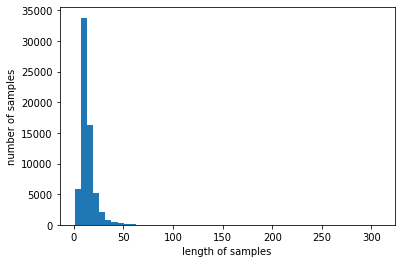

In [ ]:
# 패딩(샘플 길이 동일하게 맞춰주기)
print('리뷰의 최대 길이 :',max(len(l) for l in re_train_text))
print('리뷰의 평균 길이 :',sum(map(len, re_train_text))/len(re_train_text))

plt.hist([len(s) for s in re_train_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이 : 152
리뷰의 평균 길이 : 13.860848380624821


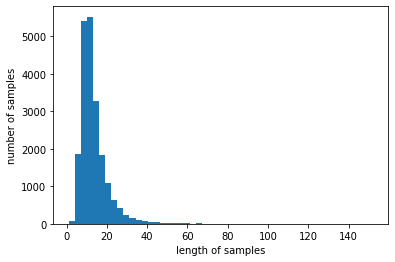

In [ ]:
# test set도 비슷한 경향을 보이지만, 그렇게 긴 리뷰길이는 없다
print('리뷰의 최대 길이 :',max(len(l) for l in re_test_text))
print('리뷰의 평균 길이 :',sum(map(len, re_test_text))/len(re_test_text))

plt.hist([len(s) for s in re_test_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 40
below_threshold_len(max_len, re_train_text)
below_threshold_len(max_len, re_test_text)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.86461538461539
전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.90130887551352


In [ ]:
# 40정도면 전체 샘플을 거의 포함하므로, 40으로 맞춘다(Pad sequences)
tr_x = pad_sequences(re_train_text, maxlen = max_len)
te_x = pad_sequences(re_test_text, maxlen = max_len)

In [ ]:
tr_x  # 패딩이 된 모습

array([[   0,    0,    0, ...,  206,   60,  282],
       [   0,    0,    0, ...,   12,  487,  381],
       [   0,    0,    0, ...,    8, 1672,  477],
       ...,
       [   0,    0,    0, ...,   61,  772,   92],
       [   0,    0,    0, ...,   94,   62,   19],
       [   0,    0,    0, ...,   52,  285,    9]], dtype=int32)

In [ ]:
te_x

array([[   0,    0,    0, ...,  722,   19,   31],
       [   0,    0,    0, ..., 2868,   62,    5],
       [   0,    0,    0, ...,   17, 1766, 4248],
       ...,
       [   0,    0,    0, ...,   61, 3122,   41],
       [   0,    0,    0, ...,  411, 1401,   39],
       [   0,    0,    0, ...,   71,  831,   15]], dtype=int32)

## Embedding

In [ ]:
# 임베딩은 Fasttext를 이용하였습니다.
from gensim.models.fasttext import FastText

In [ ]:
%%time
ft_model = FastText(train['text_token'],window = 3, min_count = 3, size = 200, iter = 100) 

CPU times: user 6min 42s, sys: 1.72 s, total: 6min 44s
Wall time: 2min 37s


In [ ]:
def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

train_data = train['text_token']
test_data = test['text_token']

input_length = 128
#pad sequence
train_pad = pad_sequences(
    sequences=vectorize_data(train_data, vocab=ft_model.wv.vocab),
    maxlen=input_length, padding='post')
test_pad = pad_sequences(
    sequences=vectorize_data(test_data, vocab=ft_model.wv.vocab),
    maxlen=input_length, padding='post')

## Modeling

In [ ]:
tr_x  # pad sequance를 거친 벡터

array([[   0,    0,    0, ...,  206,   60,  282],
       [   0,    0,    0, ...,   12,  487,  381],
       [   0,    0,    0, ...,    8, 1672,  477],
       ...,
       [   0,    0,    0, ...,   61,  772,   92],
       [   0,    0,    0, ...,   94,   62,   19],
       [   0,    0,    0, ...,   52,  285,    9]], dtype=int32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    tr_x,
    train['평점'],
    test_size=0.2,
    shuffle=True,
    random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Embedding(v_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/30
694/694 [==============================] - 12s 9ms/step - loss: 0.5240 - acc: 0.7351 - val_loss: 0.4380 - val_acc: 0.8004

Epoch 00001: val_acc improved from -inf to 0.80038, saving model to best_model.h5
Epoch 2/30
694/694 [==============================] - 6s 8ms/step - loss: 0.4073 - acc: 0.8191 - val_loss: 0.4274 - val_acc: 0.8094

Epoch 00002: val_acc improved from 0.80038 to 0.80942, saving model to best_model.h5
Epoch 3/30
694/694 [==============================] - 6s 8ms/step - loss: 0.3890 - acc: 0.8294 - val_loss: 0.4256 - val_acc: 0.8082

Epoch 00003: val_acc did not improve from 0.80942
Epoch 4/30
694/694 [==============================] - 6s 8ms/step - loss: 0.3681 - acc: 0.8417 - val_loss: 0.4207 - val_acc: 0.8095

Epoch 00004: val_acc improved from 0.80942 to 0.80952, saving model to best_model.h5
Epoch 5/30
694/694 [==============================] - 6s 8ms/step - loss: 0.3403 - acc: 0.8549 - val_loss: 0.4246 - val_acc: 0.8142

Epoch 00005: val_acc improved fr

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

407/407 [==============================] - 1s 3ms/step - loss: 0.4548 - acc: 0.8018

 테스트 정확도: 0.8018


In [ ]:
te_x

array([[   0,    0,    0, ...,  722,   19,   31],
       [   0,    0,    0, ..., 2868,   62,    5],
       [   0,    0,    0, ...,   17, 1766, 4248],
       ...,
       [   0,    0,    0, ...,   61, 3122,   41],
       [   0,    0,    0, ...,  411, 1401,   39],
       [   0,    0,    0, ...,   71,  831,   15]], dtype=int32)

In [ ]:
pred = model.predict(te_x) 

In [ ]:
pred

array([[0.401415  ],
       [0.03112592],
       [0.9028298 ],
       ...,
       [0.9054531 ],
       [0.15556313],
       [0.01912973]], dtype=float32)

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BOAZ 스터디/nlp 스터디/sample_submission.csv')
sub['평점'] = pred
sub['평점'] = sub['평점'].apply(lambda x: 1 if x >= 0.5 else 0)

sub.to_csv('/content/drive/MyDrive/Colab Notebooks/BOAZ 스터디/nlp 스터디/lstm_dev.csv', index = False)  # 0.800079